# Определение перспективного тарифа для телеком-компании

**Описание проекта**
В условной компании — федерального оператора сотовой связи, клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо выполнить предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 3 рубля ; 2. сообщение: 3 рубля; 3. 1 Гб интернет-трафика: 200 рублей.

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 1. минута разговора: 1 рубль; 2. сообщение: 1 рубль; 3. 1 Гб интернет-трафика: 150 рублей.

*Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.*

In [1]:
import pandas as pd
import numpy as np
import datetime
import scipy.stats as st
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Шаг. Откроем файл с данными и изучим общую информацию

###  Информация о звонках

In [2]:
data_calls = pd.read_csv('/datasets/calls.csv')
display(data_calls.head())
data_calls.info()
data_calls.describe()
print('Количество дубликатов', data_calls.duplicated().sum())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
Количество дубликатов 0


**Вывод**
1. Есть звонки продолжительностью 0 минут (пропущенные звонки), поэтому их не нужно удалять;
2. Пропущенных значений нет;  
3. Надо перевести время (call_date) к типу данных datetime; 
4. Время звонка округлить до целого в большую сторону.


### Информация об интернет сессиях

In [3]:
data_internet = pd.read_csv('/datasets/internet.csv')
display(data_internet.head())
data_internet.info()
data_internet.describe()
print('Количество дубликатов', data_internet.duplicated().sum())

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
Количество дубликатов 0


`Unnamed: 0` возникает, когда данные сохраняют с указанием индекса `pd.DataFrame().to_csv(..., index=column)`. Если при чтении указать этот столбец `pd.read_csv(..., index_col=0)` - данные сразу прочитаются корректно.

**Вывод**

1. Пропущенных значений нет; 
2. Надо перевести время (session_date) к типу данных datetime; 
3. Объём потраченного за сессию интернет-трафика переведем в ГБ, т.к. перерасход начисляется за гигабайты и преобразуем в int с округлением в большую сторону. 

### Информация о сообщениях

In [4]:
data_messages = pd.read_csv('/datasets/messages.csv')
display(data_messages.head())
data_messages.info()
data_messages.describe()
print('Количество дубликатов', data_messages.duplicated().sum())

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
Количество дубликатов 0


**Вывод**

1. Пропущенных значений нет; 
2. Надо перевести время (message_date) к типу данных datetime.


### Информация о тарифах

In [5]:
data_tariffs = pd.read_csv('/datasets/tariffs.csv')
display(data_tariffs.head())
data_tariffs.info()
data_tariffs.describe()
print('Количество дубликатов', data_tariffs.duplicated().sum())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
Количество дубликатов 0


**Вывод**

1. Пропущенных значений нет, с данными в целом все в порядке.

### Информация о пользователях

In [6]:
data_users = pd.read_csv('/datasets/users.csv')
display(data_users.head())
data_users.info()
data_users.describe()
print('Количество дубликатов', data_users.duplicated().sum())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
Количество дубликатов 0


**Вывод**
1. Cогласно документациия: если значение пропущено, то тариф ещё действовал на момент выгрузки данных будет корректно оставить пропущенные значения без изменений;
2. Надо перевести время (reg_date) к типу данных datetime.


## Шаг. Подготовим данные для дальнейшего анализа

### Преобразуем данные к нужным типам 

In [7]:
# приведем значения столбцов call_date, session_date, message_date, reg_date к типу данных datetime
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')

### Найдем дополнительные данные для анализа и исправим ошибки

In [8]:
# добавляем столбец month в data_calls, data_internet, data_messages
# находим количество сделанных звонков и израсходованных минут разговора по месяцам
data_calls['month'] = pd.to_datetime(data_calls['call_date']).dt.month

# находим объем израсходованного интернет-трафика по месяцам
data_internet['month'] = pd.to_datetime(data_internet['session_date']).dt.month

# находим количество отправленных сообщений по месяцам
data_messages['month'] = pd.to_datetime(data_messages['message_date']).dt.month

In [9]:
# в таблице с интернет-трафиком и тарифом для дальнейшего анализа переведем мб в гб
data_internet['gb_used'] = data_internet['mb_used'] /1024
data_tariffs['gb_per_month_included'] = data_tariffs['mb_per_month_included'] / 1024

In [10]:
# округлим в большую сторону звонки 
data_calls['duration'] = np.ceil(data_calls['duration']) 

### Создадим новый датасет и наполним его необходимыми данными

- user_id - уникальный идентификатор пользователя
- month - месяц, где 1 - это январь, а 12 - декабрь.
- count_calls - количество звонков
- sum_minut - общая продолжительность звонков
- count_messages - количество сообщений
- sum_gb - количество израсходованного трафика, в гб

In [11]:
# cоздадим свобную таблицу длительности звонков по пользователям и месяцам,выведем кол-во звонков и сумму продолжительности звонков в минутах 
data_calls_pivot = data_calls.pivot_table(index = ['user_id','month'], values = 'duration' , aggfunc= ['count','sum']).reset_index()

# изменим название для удобства, чтобы название соответствовало содержимому
data_calls_pivot.columns = ['user_id', 'month', 'count_calls', 'sum_minut']

# приведем в целочисленный тип
data_calls_pivot['sum_minut'] = data_calls_pivot['sum_minut'].astype('int64')

data_calls_pivot.head()

,user_id,month,count_calls,sum_minut
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [12]:
# cоздадим свобную таблицу кол-во сообщений по пользователям и месяцам, выведем кол-во сообщений
data_messages_pivot = data_messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count').reset_index()

# изменим название для удобства, чтобы название соответствовало содержимому
data_messages_pivot.columns = ['user_id', 'month', 'count_messages']

# приведем в целочисленный тип
data_messages_pivot['count_messages'] = data_messages_pivot['count_messages'].astype('int64')

data_messages_pivot.head()

,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [13]:
# cоздадим свобную таблицу кол-во израсходованного трафика в гб по пользователям и месяцам, выведем кол-во израсходованного трафика
data_internet_pivot = data_internet.pivot_table(index=['user_id', 'month'], values='gb_used', aggfunc='sum').reset_index()     

# изменим название для удобства, чтобы название соответствовало содержимому
data_internet_pivot.columns = ['user_id', 'month', 'sum_gb']

# округлим кол-во сумму гигабайт
data_internet_pivot['sum_gb'] = data_internet_pivot['sum_gb'].apply(np.ceil)

data_internet_pivot.head()

,user_id,month,sum_gb
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


In [14]:
# cоединим полученные данные сгрупированые по месяцам в один датасет
# применим метод merge к подготовленным ранее сводным таблицам 
data=data_calls_pivot.merge(data_messages_pivot, on=['user_id', 'month'], how='outer')

data = data.merge(data_internet_pivot,  on = ['user_id','month'], how = 'outer')

# добавим в таблицу значение тарифа и города
data = data.merge(data_users[['user_id','tariff','city']], on = 'user_id')

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   count_calls     3174 non-null   float64
 3   sum_minut       3174 non-null   float64
 4   count_messages  2717 non-null   float64
 5   sum_gb          3203 non-null   float64
 6   tariff          3214 non-null   object 
 7   city            3214 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 226.0+ KB


,user_id,month,count_calls,sum_minut,count_messages,sum_gb,tariff,city
0,1000,5,22.0,159.0,22.0,3.0,ultra,Краснодар
1,1000,6,43.0,172.0,60.0,23.0,ultra,Краснодар
2,1000,7,47.0,340.0,75.0,14.0,ultra,Краснодар
3,1000,8,52.0,408.0,81.0,14.0,ultra,Краснодар
4,1000,9,58.0,466.0,57.0,15.0,ultra,Краснодар


Вместо этих 2 строк:
    
    data = data.merge(data_users[['user_id','tariff']], on = 'user_id')
    data = data.merge(data_users[['user_id','city']], on = 'user_id')
    
можно сделать сразу так:
    
    data = data.merge(data_users[['user_id','tariff','city']], on = 'user_id')
    

### Найдем помесячную выручку с каждого пользователя

In [15]:
#вспомним условия каждого тарифа
data_tariffs.head() 

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


In [16]:
def price(df):
    sum_minut = df['sum_minut']
    count_messages = df['count_messages']
    sum_gb = df['sum_gb']
    tariff = df['tariff']
    if tariff == 'smart':
        if sum_minut > 500:
            price_min=(sum_minut-500)*3 # стоимость минут потраченных сверх тарифа
        else:
            price_min = 0
        if count_messages > 50:
            price_message=(count_messages-50)*3 # стоимость сообщений потраченных сверх тарифа
        else:
            price_message = 0
        if sum_gb > 15:
            price_gb=(sum_gb-15)*200 # стоимость гб потраченных сверх тарифа
        else:
            price_gb = 0
        return price_min + price_message + price_gb + 550 # цена за месяц: тариф + потраченное сверху
    elif tariff == 'ultra':
        if sum_minut > 3000:
            price_min=sum_minut-3000 # стоимость минут потраченных сверх тарифа
        else:
            price_min = 0
        if count_messages > 1000:
            price_message=count_messages-1000 #стоимость сообщений потраченных сверх тарифа
        else:
            price_message = 0
        if sum_gb > 30:
            price_gb=(sum_gb-30)*150 #стоимость гб потраченных сверх тарифа
        else:
            price_gb = 0
        return price_min + price_message + price_gb + 1950 # цена за месяц: тариф + потраченное сверху
   
data['price_month'] =  data.apply(price, axis=1) # новый столбец, функцию ко всей строке


In [17]:
# проверим результат
display(data.head()) 
data.info()

,user_id,month,count_calls,sum_minut,count_messages,sum_gb,tariff,city,price_month
0,1000,5,22.0,159.0,22.0,3.0,ultra,Краснодар,1950.0
1,1000,6,43.0,172.0,60.0,23.0,ultra,Краснодар,1950.0
2,1000,7,47.0,340.0,75.0,14.0,ultra,Краснодар,1950.0
3,1000,8,52.0,408.0,81.0,14.0,ultra,Краснодар,1950.0
4,1000,9,58.0,466.0,57.0,15.0,ultra,Краснодар,1950.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   count_calls     3174 non-null   float64
 3   sum_minut       3174 non-null   float64
 4   count_messages  2717 non-null   float64
 5   sum_gb          3203 non-null   float64
 6   tariff          3214 non-null   object 
 7   city            3214 non-null   object 
 8   price_month     3214 non-null   float64
dtypes: float64(5), int64(2), object(2)
memory usage: 251.1+ KB


**Вывод**

На основании первичных данных был создан датафрейм со следующей информацией:

user_id - уникальный идентификатор пользователя;
month - месяц, где 1 - это январь, а 12 - декабрь;
count_calls - количество звонков;
sum_minut - общая продолжительность звонков;
count_messages - количество сообщений;
sum_gb   - количество израсходованного трафика, в мб;
tariff - название тарифного плана;
city - город проживание пользователя;
price_month  - помесячная выручка.

## Шаг. Проанализируем данные 

### Определим медиану и среднее количество, дисперсию и стандартное отклонение 

In [18]:
# посчитаем среднее количество, дисперсию и стандартное отклонение тарифов SMART и UlTRA
data.pivot_table(index = 'tariff', 
                    values = ['sum_minut',
                              'count_messages',
                              'sum_gb'
                             ], 
                    aggfunc = ['mean',
                               'var',
                               'std']
                   )

mean                                   var             \
       count_messages     sum_gb   sum_minut count_messages     sum_gb   
tariff                                                                   
smart       38.716441  16.336176  419.062978     717.594201  32.923756   
ultra       61.161006  19.694359  545.451104    2109.659183  94.146734   

                                std                        
           sum_minut count_messages    sum_gb   sum_minut  
tariff                                                     
smart   35844.189551      26.787949  5.737923  189.325618  
ultra   94203.418396      45.931026  9.702924  306.925754

### Определим среднее, дисперсию и стандартное отклонение для помесячной выручки Посмотрим на гистограмму распределения¶

In [19]:
# посчитаем среднее количество, дисперсию и стандартное отклонение помесячной выручки тарифов SMART и UlTRA
data.pivot_table(index = 'tariff', 
                 values = 'price_month', 
                 aggfunc = ['mean',
                            'var',
                            'std'
                              ]
                   )

,mean,var,std
,price_month,price_month,price_month
tariff,,,
smart,1289.973531,669785.708006,818.404367
ultra,2070.152284,141516.745079,376.187114


 **Вывод**
Из полученных результатов можно описать поведение пользователей следующим образом. 
Пользователи тарифа Смарт в среднем используют 419 мин разговора, 39 смс и 16,3 Гб интернет-трафика. 
Пользователи тарифа Ультра в среднем используют 545 мин разговора, 62 смс и 19,7 Гб интернет-трафика. 
Исходя из этого можно сделать вывод, что в среднем минуты разговора, включённые в оба тарифа, удовлетворяют нужды пользователей, так же в среднем количества смс, включённые в оба тарифа больше, чем количество смс отправленных в среднем. 
Однако, в тарифе Смарт пользователи чаще уходят за рамки тарифного пакета интернет-трафика, это означает, что часть пользователей докупает интернет-трафик. А пользователи тарифа Ультра не превышают интернет-трафик включенный в тариф, что означает,  пользователям данного тарифа не нужно докупать дополнительный интернет-трафик.



###  Построим гистограммы распределения

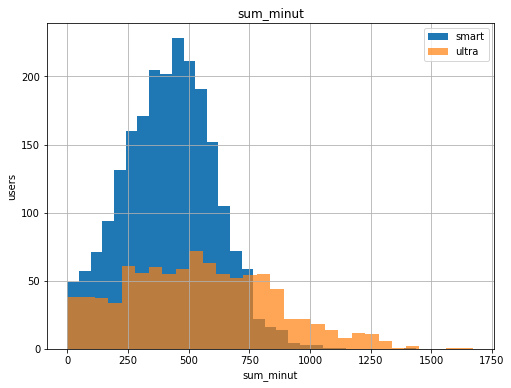

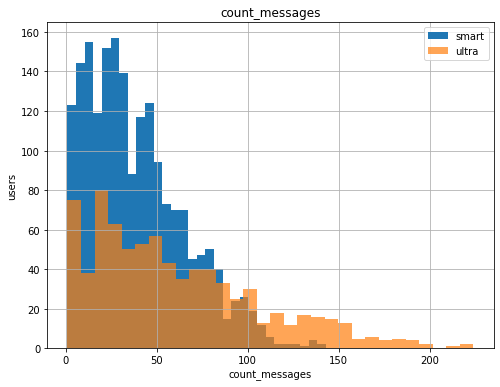

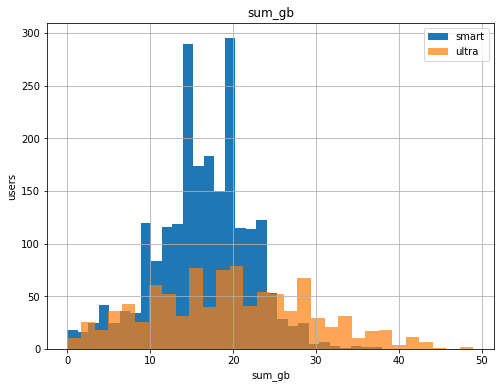

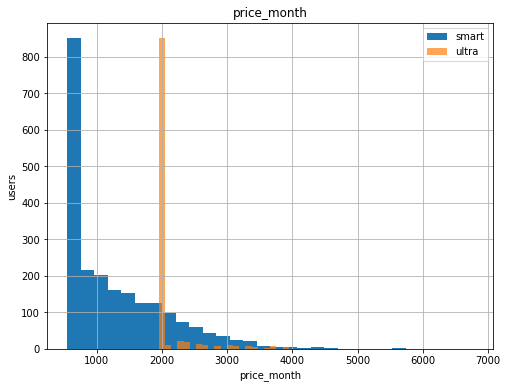

In [20]:
# построим гистограммы распределения 
list_of_columns=['sum_minut','count_messages','sum_gb', 'price_month']

tariffs = ['ultra','smart']
for column in list_of_columns:
        data.loc[data.loc[:,'tariff'] == 'smart'][column].plot(
            kind = 'hist',
            bins = 30,
            label = 'smart', 
            figsize = (8,6),
            grid=True
        )
        data.loc[data.loc[:,'tariff'] == 'ultra'][column].plot(
            kind = 'hist',
            bins = 30,
            alpha =0.7,
            label = 'ultra',
            figsize = (8,6),
            grid=True
        )
        plt.title(column)
        plt.xlabel(column)
        plt.ylabel('users')
        plt.legend()
        plt.show()
        

**Вывод**

1.Гистограмма распределения плотности среднего значения длительности звонков имеет нормальное распределение и скошен влево.
2.Гистограмма распределения плотности среднего значения сообщений имеет нормальное распределение и скошен влево.
3.Гистограмма распределения плотности среднего значения интернет-трафика имеет нормальное распределение.
4.Гистограмма распределения плотности среднего значения выручки имеет нормальное распределение.

По гистограммам наглядно видно, что по тарифу Смарт примерно 20% абонентов выходят за границы звонков, 10% за границы сообщений и около 35% выходят за границы трафика. По тарифу Ультра примерно 10% абонентов выходят за границы трафика. Также на гистограммах видно, что более популярен тариф Смарт.


## Проверим гипотезы

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Гипотеза о равенстве средних двух генеральных совокупностей, следовательно:

**Нулевая гипотеза**: средняя выручка пользователей тарифов Ультра и Смарт равны.

**Альтернативная гипотеза**: средняя выручка пользователей тарифов Ультра и Смарт различается.

Проверим нулевую гипотезу.

In [21]:
# проверяем нулевую гипотезу
alpha = .05
price_month_ultra = data.loc[data.loc[:,'tariff'] == 'ultra']['price_month']
price_month_smart = data.loc[data.loc[:,'tariff'] == 'smart']['price_month']
result = st.ttest_ind(price_month_ultra, price_month_smart)
prob = result.pvalue
print('p-значение:', prob)
if prob < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


**Вывод**

Очень низкое p-значение (значение вероятности) - средняя выручка пользователей тарифов Ультра и Смарт различается. 

Отвергаем нулевую гипотезу.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
Следовательно:

**Нулевая гипотеза**: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

**Альтернативная гипотеза**: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Проверим нулевую гипотезу.

In [22]:
# проверяем нулевую гипотезу
alpha = .05
city_moscow = data.loc[data.loc[:,'city'] == 'Москва']['price_month']
city_other = data.loc[data.loc[:,'city'] != 'Москва']['price_month']
result_city = st.ttest_ind(city_moscow, city_other) 
prob_city = result_city.pvalue
print('p-значение:', prob_city)
if prob_city < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Высокое p-значение/значение вероятности - cредняя выручка пользователей из Москвы близка к равной выручке пользователей из других регионов.

Не получилось отвергнуть нулевую гипотезу.

## Общий вывод

1.	Данные со звонками, сообщениями и интернетом, пользователями не содержали пропущенных значений, нет дубликатов. В таблице звонков была продолжительность 0.0 минут, это не отвеченные звонки, не имеет смысла их убирать, т.к. для анализа суммируем сумму минут за месяц. В целом данные приходят без артефактов и достаточно чистые.
2.	Пользователи тарифа Смарт в среднем используют 433 мин разговора, 39 смс и 15,3 Гб интернет-трафика. Пользователи тарифа Ультра в среднем используют 572 мин разговора, 62 смс и 18,6 Гб интернет-трафика. Исходя из этого можно сделать вывод, что в среднем минуты разговора, включённые в оба тарифа, удовлетворяют нужды пользователей, так же в среднем количества смс, включённые в оба тарифа больше, чем количество смс отправленных в среднем. Однако, в тарифе Смарт пользователи чаще уходят за рамки тарифного пакета интернет-трафика, это означает, что часть пользователей докупает интернет-трафик. А пользователи тарифа Ультра не превышают интернет-трафик включенный в тариф, что означает, пользователям данного тарифа не нужно докупать дополнительный интернет-трафик.
3.	Средняя выручка пользователей тарифов Ультра и Смарт не может быть равной.
4.	Средняя выручка пользователей из Москвы близка к равной выручке пользователей из других регионов.

Рекламный бюджет выгоднее всего перераспределить в пользу тарифа Ультра несмотря на то, что его пользователи меньше выходят за рамки тарифного пакета, в отличие от абонентов тарифа Смарт.Так же можно заметить, что медианное и среднее значение дохода у абонентов тарифа Ультра выше. Кроме того, в процессе анализа  узнали, что в среднем разница медианных и среднеарифметических значений дохода с разных тарифов отличается ~1000 в пользу тарифа Ультра.
